# Task 1C

In [ ]:
# Importing Libraries
from sentence_transformers import SentenceTransformer, losses, InputExample, evaluation
import pandas as pd
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [ ]:
# Getting the data
train_df = pd.read_csv('train.csv', sep='\t')
dev_df = pd.read_csv('dev.csv', sep='\t')

train_dataset = [InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score'] / 5.0)
                 for _, row in train_df.iterrows()]
dev_dataset = [InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score'] / 5.0)
               for _, row in dev_df.iterrows()]

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
dev_loader = DataLoader(dev_dataset, shuffle=False, batch_size=16)

In [ ]:
# Load the pre-trained BERT model
model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')

# Freezing earlier layers
num_params = 0
for name, child in model.named_children():
    if name == '0':
        for param in child.parameters():
            # print(param)
            num_params += 1
            param.requires_grad = False

current_params = 0
for name, child in model.named_children():
    if name == '0':
        for param in child.parameters():
            # print(param)
            current_params += 1
            if current_params >= num_params - 49:
                param.requires_grad = True

# Loss function
loss_function = losses.CosineSimilarityLoss(model)

In [1]:
# Print out the names of the parameters that will still be updated
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

0.auto_model.embeddings.word_embeddings.weight
0.auto_model.embeddings.position_embeddings.weight
0.auto_model.embeddings.token_type_embeddings.weight
0.auto_model.embeddings.LayerNorm.weight
0.auto_model.embeddings.LayerNorm.bias
0.auto_model.encoder.layer.0.attention.self.query.weight
0.auto_model.encoder.layer.0.attention.self.query.bias
0.auto_model.encoder.layer.0.attention.self.key.weight
0.auto_model.encoder.layer.0.attention.self.key.bias
0.auto_model.encoder.layer.0.attention.self.value.weight
0.auto_model.encoder.layer.0.attention.self.value.bias
0.auto_model.encoder.layer.0.attention.output.dense.weight
0.auto_model.encoder.layer.0.attention.output.dense.bias
0.auto_model.encoder.layer.0.attention.output.LayerNorm.weight
0.auto_model.encoder.layer.0.attention.output.LayerNorm.bias
0.auto_model.encoder.layer.0.intermediate.dense.weight
0.auto_model.encoder.layer.0.intermediate.dense.bias
0.auto_model.encoder.layer.0.output.dense.weight
0.auto_model.encoder.layer.0.output.dens

In [ ]:
# Training the model
model.fit(train_objectives=[(train_loader, loss_function)], epochs=2,
          warmup_steps=100, evaluator=None, output_path='model1C')

In [ ]:
# Loading the model
model = SentenceTransformer('model1C')

In [2]:
epoches = 3
train_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(train_dataset, name='train')
eval_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_dataset, name='dev')
train_losses = [1 - model.evaluate(train_evaluator)]
eval_losses = [1 - model.evaluate(eval_evaluator)]
for epoch in range(epoches):
    print(f'\nEpoch: {epoch + 1}')
    model.fit(train_objectives=[(train_loader, loss_function)], epochs=1,
              warmup_steps=100, evaluator=None, output_path='output')
    train_losses.append(1 - model.evaluate(train_evaluator))
    eval_losses.append(1 - model.evaluate(eval_evaluator))

train_losses, eval_losses


Epoch: 1

Epoch: 2

Epoch: 3


([0.2539888691082125,
  0.15885995007824982,
  0.13362412293643267,
  0.11506678224090261],
 [0.2004707010670541,
  0.13013287523799144,
  0.12398067535364943,
  0.12070270859524124])

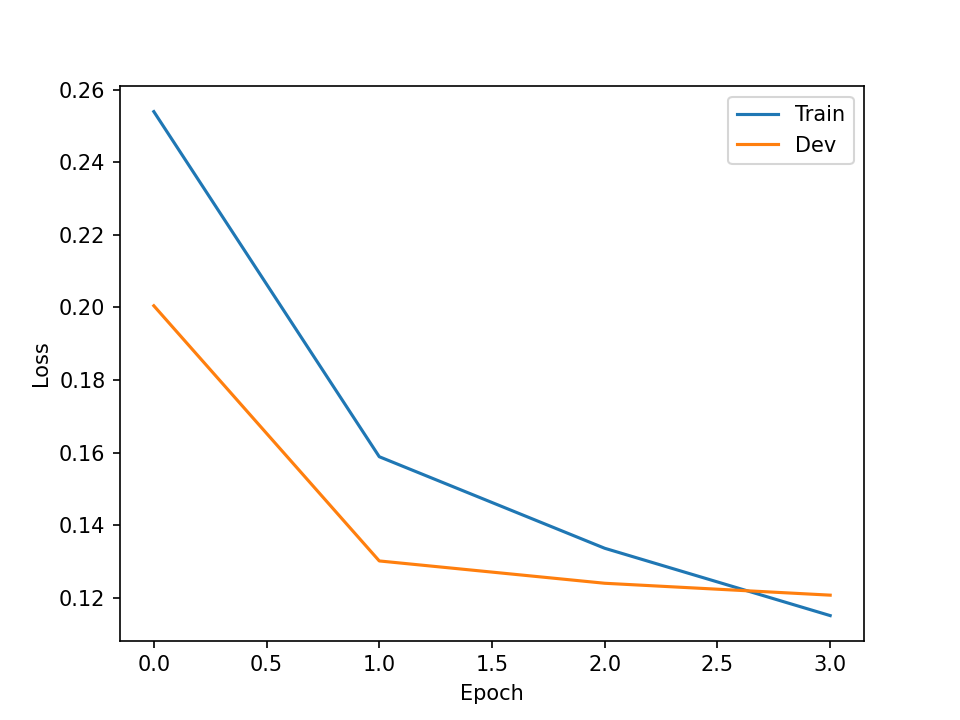

In [3]:
plt.plot(range(epoches + 1), train_losses, label='Train')
plt.plot(range(epoches + 1), eval_losses, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
# Evaluating
evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(dev_dataset, name='dev')
model.evaluate(evaluator)

0.8792972914047588